# Анализ событий

## ✅ **Сравнение подходов 2.1 и 2.2**

| Критерий | **2.1. Фиксированные интервалы (бины)** | **2.2. Скользящее окно (rolling window)** |
|----------|------------------------------------------|-------------------------------------------|
| Простота реализации | Очень прост в SQL и BI | Требует оконных функций или Pandas |
| Вычислительная нагрузка | Минимальная | Выше (много пересекающихся окон) |
| Детализация | Нормальная | Очень высокая, "плавный" график |
| Устойчивость к шуму | Может быть шумным | Сглаживает всплески и выбросы |
| Поиск аномалий | Менее чувствительный | Лучше обнаруживает локальные пики |
| Визуализация | Хорошо ложится в столбчатую гистограмму | Хорош для линий (line charts) |

---

## 🎯 **Рекомендации по применению**

### 🔹 Используй **2.1 (фиксированные бины)**, если:
- Ты хочешь **понять общую нагрузку** за период (день/неделю/месяц).
- Нужно сделать **простую гистограмму или столбчатый график**.
- Тебе важно видеть, **в какие часы было больше всего событий**.
- Нужно **рассчитать описательную статистику** по «срезам» времени.

### 🔹 Используй **2.2 (скользящее окно)**, если:
- Нужно **отслеживать аномалии, всплески, перегрузки**, которые могут затеряться между бин-наблюдениями.
- Хочешь сделать **более гладкий график** с меньшим шумом.
- У тебя **высокочастотные события** (много событий в минуту).
- Нужно находить **локальные закономерности**, а не только общие тренды.

---

## 🧠 **Дополнительные подходы для анализа временных рядов**

### 1. **Moving average / EWMA**
- Сглаженные тренды — простой способ выявить долгосрочные изменения.
- EWMA (Exponentially Weighted Moving Average) — придает больший вес свежим данным.

### 2. **Seasonal decomposition**
- Если данные цикличные (дни недели, часы суток), можно выделить тренд, сезонность и остатки.
- Очень полезно для CA, особенно если нагрузка растет по будням и падает по выходным.

### 3. **Clustering временных интервалов**
- Например, кластеризовать часы по активности (высокая, средняя, низкая).
- Используется для обнаружения "типичных" паттернов.

### 4. **Анализ плотности событий (event rate)**
- Не просто считать, сколько событий произошло, а **оценить интенсивность**: сколько событий в среднем за 1 минуту / 1 секунду.

### 5. **Корреляционный анализ**
- Связь между метриками: например, рост "одновременных запросов" → рост "времени выпуска".

---

## 🧪 Вывод и рекомендации

**Для начала анализа:**  
✅ Начни с **2.1 (фиксированные бины)**: легко реализуется, понятно, даст базовую картину.  
🔍 Потом добавь **2.2 (скользящие окна)** — особенно для всплесков, отказов, аномалий.

**Если задача — мониторинг и визуализация:**  
- Бины подойдут для **дашбордов** в Superset / Grafana.
- Скользящее окно — для **алертов и продвинутой аналитики**.

## 1. Построение распределения количества выпусков сертификатов по временным биннам

**Идея:**  
- Есть столбец с отметками времени (например, `event_time`) для каждого события выпуска сертификата.
- Нужно «сгруппировать» события по заданному интервалу (бин) и посчитать число событий в каждом таком бинне.

**Пример кода:**

```python
import pandas as pd
import matplotlib.pyplot as plt

# Предположим, данные загружены в DataFrame df с колонкой 'event_time'
# и все строки соответствуют выпуску сертификата
# Преобразуем колонку к типу datetime:
df['event_time'] = pd.to_datetime(df['event_time'])

# Установим event_time в качестве индекса:
df.set_index('event_time', inplace=True)

# Определим бин, например, 5 минут
bin_size = '5T'  # "T" означает минуты

# Группируем по интервалам и считаем количество событий:
counts = df.resample(bin_size).size()

# Построим график распределения:
plt.figure(figsize=(12, 6))
counts.plot(kind='bar')
plt.title(f'Количество выпусков сертификатов по интервалам {bin_size}')
plt.xlabel('Время')
plt.ylabel('Количество событий')
plt.tight_layout()
plt.show()
```

*Объяснение:*  
- `pd.to_datetime` преобразует строковые даты к типу datetime.  
- `set_index` устанавливает временной индекс для удобной ресемплинга.  
- `resample(bin_size).size()` группирует данные по интервалам указанной длины (например, по 5 минутам) и считает число строк (событий) в каждом интервале.

---

## 2. Анализ распределения: среднее, медиану, стандартное отклонение и т.д.

После того как у нас есть серия значений (количество событий в каждом бине), можно рассчитать статистику:

```python
mean_count = counts.mean()
median_count = counts.median()
std_count = counts.std()
min_count = counts.min()
max_count = counts.max()

print(f"Среднее: {mean_count:.2f}")
print(f"Медиана: {median_count}")
print(f"Стандартное отклонение: {std_count:.2f}")
print(f"Минимум: {min_count}")
print(f"Максимум: {max_count}")
```

*Объяснение:*  
Методы `mean()`, `median()`, `std()`, `min()` и `max()` – стандартные функции pandas для описательной статистики. Они дают тебе представление о центральной тенденции (среднее, медиана) и разбросе (стандартное отклонение, минимум, максимум).

---

## 3. Поиск закономерностей, всплесков, аномалий

Чтобы выявить закономерности и аномалии в распределении:
- Построй графики временных рядов (линейный график вместо бар-графика) — это позволяет видеть пики (всплески).
- Построй boxplot (ящичковую диаграмму) для оценки выбросов.
- Рассчитай z-скор для каждого интервала.

**Пример:**

```python
import numpy as np

# Линейный график с временной серией:
plt.figure(figsize=(12, 6))
counts.plot()
plt.title(f'Временной ряд количества выпусков сертификатов ({bin_size})')
plt.xlabel('Время')
plt.ylabel('Количество событий')
plt.show()

# Boxplot для обнаружения выбросов:
plt.figure(figsize=(6, 8))
plt.boxplot(counts.dropna())
plt.title(f'Boxplot количества выпусков сертификатов ({bin_size})')
plt.ylabel('Количество событий')
plt.show()

# Вычисление z-скоров:
z_scores = (counts - mean_count) / std_count
anomalies = counts[z_scores.abs() > 2]  # выберем значения, где z-score > 2 как аномальные
print("Аномальные интервалы:")
print(anomalies)
```

*Объяснение:*  
- Линейный график поможет визуально определить периоды, когда наблюдаются всплески.
- Boxplot показывает распределение и выбросы.
- Z-скор помогает количественно выделить интервалы, где значение сильно отличается от среднего (обычно |z| > 2 считается аномалией).

---

## 4. Выбор временного бина

**Подход:**  
- Попробуй несколько вариантов: 1 минута, 5 минут, 10 минут, 30 минут.
- Посмотри на визуализацию и описательную статистику:
  - Если слишком маленький бин (1 минута), график может быть очень «шумным».
  - Если слишком большой бин (30 минут), можно сгладить важные детали (всплески).

**Рекомендация:**  
Начни с 5-10 минутных интервалов. Если данные кажутся слишком детализированными, попробуй увеличить интервал до 10 минут. Если важных всплесков не видно — уменьши до 5 или даже 1 минуты.

---

## 5. Определение «нормы», «аномалии» и «критичных» значений для бина

Можно установить пороги на основе описательной статистики:
- **Норма:** число выпусков в бине лежит в пределах (mean ± 1σ).
- **Аномалия:** число выпусков выходит за пределы (mean ± 2σ).  
- **Критично:** число выпусков выходит за пределы (mean ± 3σ) или в абсолютном смысле в разы превышает среднее.

Например:

```python
lower_normal = mean_count - std_count
upper_normal = mean_count + std_count

lower_anomaly = mean_count - 2 * std_count
upper_anomaly = mean_count + 2 * std_count

lower_critical = mean_count - 3 * std_count
upper_critical = mean_count + 3 * std_count

print(f"Норма: [{lower_normal:.2f}, {upper_normal:.2f}]")
print(f"Аномально: [{lower_anomaly:.2f}, {upper_anomaly:.2f}]")
print(f"Критично: [{lower_critical:.2f}, {upper_critical:.2f}]")
```

*Объяснение:*  
Эти пороги можно использовать как ориентиры для настройки алертов. Если значение выходит за пределы upper_critical, это уже требует немедленного реагирования.

---

## 6. Скользящее окно для обнаружения локальных закономерностей, пиков, выбросов

**Идея:**  
Построение скользящего окна позволяет рассчитать статистические показатели по «движущемуся» окну, что помогает выявлять локальные всплески.

**Пример:**

```python
# Пусть у нас окно 5 минут, с шагом в 1 минуту.
# Для этого нужно сначала изменить размер бина на 1 минуту.
counts_1min = df.resample('1T').size()

# Вычислим скользящие статистики с окном в 5 периодов (минут):
window_size = 5

rolling_mean = counts_1min.rolling(window=window_size).mean()
rolling_median = counts_1min.rolling(window=window_size).median()
rolling_min = counts_1min.rolling(window=window_size).min()
rolling_max = counts_1min.rolling(window=window_size).max()

plt.figure(figsize=(12, 6))
plt.plot(counts_1min.index, counts_1min, label='1-Minute Count', alpha=0.5)
plt.plot(rolling_mean.index, rolling_mean, label=f'{window_size}-Minute Rolling Mean', color='red')
plt.plot(rolling_median.index, rolling_median, label=f'{window_size}-Minute Rolling Median', color='green')
plt.xlabel('Время')
plt.ylabel('Количество выпусков сертификатов')
plt.title('Скользящие статистики (Окно 5 минут, шаг 1 минута)')
plt.legend()
plt.show()
```

*Объяснение:*  
- Мы меняем бины на 1 минуту для большей детализации.
- Метод `rolling(window=...)` вычисляет статистику по указанному окну.
- Построение графика позволяет визуально оценить локальные пики и выбросы.

---

## 7. Реализация метода EWMA

**EWMA (Exponentially Weighted Moving Average)** позволяет сгладить временной ряд, придавая больший вес последним наблюдениям.

**Пример кода:**

```python
# Расчет EWMA с параметром span (например, span=10)
ewma = counts_1min.ewm(span=10, adjust=False).mean()

plt.figure(figsize=(12, 6))
plt.plot(counts_1min.index, counts_1min, label='1-Minute Count', alpha=0.5)
plt.plot(ewma.index, ewma, label='EWMA (span=10)', color='purple')
plt.xlabel('Время')
plt.ylabel('Количество выпусков сертификатов')
plt.title('EWMA сглаживание временного ряда')
plt.legend()
plt.show()
```

*Объяснение:*  
- Метод `ewm(span=10, adjust=False)` создает экспоненциальное сглаживание с параметром `span`.  
- Меньший span делает сглаживание более чувствительным к новым данным, больший — более плавным.

---

## 8. Реализация метода кластеризации временных интервалов

**Цель:** Определить, в какие интервалы наблюдаются схожие уровни активности. Например, сгруппировать интервалы по числу выпусков.

**Пример с использованием scikit-learn и KMeans:**

```python
from sklearn.cluster import KMeans
import numpy as np

# Пусть мы используем фиксированные бины (например, 5-минутные интервалы).
# counts уже содержит количество событий для каждого 5-минутного интервала.
# Преобразуем серию в numpy массив и приведем к формату 2D для KMeans.
X = counts.values.reshape(-1, 1)

# Определим количество кластеров (например, 3: низкая, средняя, высокая активность)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X)

# Добавляем кластерную метку к серии (по индексам биннов)
counts_clustered = pd.DataFrame({'count': counts, 'cluster': clusters}, index=counts.index)

# Визуализируем:
plt.figure(figsize=(12, 6))
for cluster in np.unique(clusters):
    subset = counts_clustered[counts_clustered['cluster'] == cluster]
    plt.scatter(subset.index, subset['count'], label=f'Cluster {cluster}', s=10)
plt.xlabel('Время')
plt.ylabel('Количество выпусков сертификатов')
plt.title('Кластеризация временных интервалов по выпуску сертификатов')
plt.legend()
plt.show()
```

*Объяснение:*  
- Мы используем KMeans для группировки значений количества событий.
- После кластеризации можно оценить, в каких временных интервалах наблюдаются аномально высокие или низкие значения.

---

## 9. Анализ плотности событий (event rate) с использованием Kernel Density Estimation

**Пример:** Используем seaborn для оценки плотности распределения количества выпусков.

```python
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.kdeplot(counts_1min.dropna(), bw_adjust=0.5)
plt.title('Оценка плотности количества выпусков сертификатов за 1 минуту')
plt.xlabel('Количество выпусков')
plt.ylabel('Плотность')
plt.show()
```

*Объяснение:*  
- `sns.kdeplot` строит оценку плотности ядра по данным.
- Это позволяет увидеть распределение интенсивности событий (например, существуют ли «хвосты», означающие аномально высокую активность).

---

## 10. Выбор фиксированного бина

**Рекомендации:**  
- Если событий много (78000 за день ≈ 54 события/мин), бин в **1 минуту** может дать избыточную детализацию и высокий шум.
- Начни с **5-минутных** интервалов, затем протестируй 10-минутные и 1-минутные.
- Сравни визуально распределения и рассчитанную статистику.
- Выбери бин, который позволяет чётко выделить тренды и аномалии, но не слишком «шумный».

---

## 11. Оценка подхода для скользящего окна и дальнейший продвинутый анализ

**Твой подход:**  
- Бин: 5 минут, шаг: 1 минута.
- Вычислять на каждом шаге статистики (среднее, медиану, минимум, максимум).
- Построение линейного графика на основе скользящих вычислений.

**Что можно добавить:**
- **Стандартное отклонение:** вычислять rolling std, чтобы понять изменчивость внутри окна.
- **Z-score:** на базе скользящего окна можно вычислять z-score, чтобы автоматически обнаруживать аномалии (например, значения, выходящие за пределы mean ± 2*std).
- **Динамическое пороговое значение:** можно использовать EWMA для определения динамических порогов.
- **Разложение временного ряда:** с помощью сезонного разложения (например, `statsmodels.tsa.seasonal_decompose`), чтобы выделить тренд, сезонную составляющую и остатки.
- **Алгоритмы машинного обучения:** например, метод локтя для определения аномалий, Isolation Forest, LOF (Local Outlier Factor) для обнаружения выбросов.

**Дополнительный код для скользящего окна с z-score:**

```python
# Используем бин 5 минут, но сначала агрегируем данные с этим бинном
counts_5min = df.resample('5T').size()

# Скользящее окно, например, 1 час (12 интервалов по 5 минут)
window_size = 12
rolling_mean = counts_5min.rolling(window=window_size).mean()
rolling_std = counts_5min.rolling(window=window_size).std()

# Вычисляем z-score для каждого 5-минутного интервала
z_score = (counts_5min - rolling_mean) / rolling_std

# Определяем аномалии, где z_score > 2 или < -2
anomalies = counts_5min[z_score.abs() > 2]

plt.figure(figsize=(12, 6))
plt.plot(counts_5min.index, counts_5min, label='5-Minute Count')
plt.plot(rolling_mean.index, rolling_mean, label='Rolling Mean (1h)', color='red')
plt.scatter(anomalies.index, anomalies, color='orange', label='Anomalies')
plt.xlabel('Время')
plt.ylabel('Количество выпусков сертификатов')
plt.title('Скользящее окно и аномалии с использованием z-score')
plt.legend()
plt.show()
```

*Объяснение:*  
- Для каждого окна рассчитывается среднее и стандартное отклонение.
- На их основе вычисляется z-score.
- Интервалы с |z| > 2 считаются аномальными и визуализируются.

---

## Итоговые рекомендации

1. **Начни с фиксированных интервалов (например, 5 минут)** и рассчитай базовую описательную статистику.
2. **Построй графики** (гистограммы, линейные графики, boxplot) для визуального понимания распределения.
3. **Используй скользящее окно** для выявления локальных закономерностей, пиков и аномалий (с шагом 1 минута для окна 5 или 10 минут).
4. **Применяй методы сглаживания (EWMA)**, сезонное разложение и z-score для автоматического выявления аномальных значений.
5. **Проводите кластеризацию** временных интервалов, чтобы разбить день на типовые периоды нагрузки.
6. **Анализ плотности событий** поможет понять распределение интенсивности запросов.

Эти подходы можно комбинировать в дашбордах или автоматизированных отчетах, что позволит не только проводить исследовательский анализ, но и настроить алерты для продвинутой аналитики.

Если у тебя возникнут дополнительные вопросы или понадобится помощь с конкретными кодовыми примерами — обращайся!

### **1. Построить распределение количества выпусков по бинам времени**
```python
import pandas as pd
import matplotlib.pyplot as plt

# Пример: у тебя есть датафрейм с колонкой 'timestamp' — временем события
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

# Группировка по 10 минутам
bin_size = '10min'
cert_counts = df.resample(bin_size).size()

# Визуализация
cert_counts.plot(kind='line', figsize=(15, 5), title=f'Выпуски сертификатов каждые {bin_size}')
plt.xlabel('Время')
plt.ylabel('Количество выпусков')
plt.grid(True)
plt.show()
```

---

### **2. Анализ описательных статистик**
```python
print(cert_counts.describe())  # Среднее, медиана, std и т.д.
```

---

### **3. Поиск закономерностей, всплесков, аномалий**

#### EWMA для сглаживания и поиска отклонений:
```python
ewma = cert_counts.ewm(span=6).mean()
std_dev = cert_counts.rolling(window=6).std()

plt.figure(figsize=(15, 5))
plt.plot(cert_counts, label='Оригинальные значения')
plt.plot(ewma, label='EWMA', color='orange')
plt.fill_between(cert_counts.index, ewma + 2*std_dev, ewma - 2*std_dev, color='gray', alpha=0.3)
plt.legend()
plt.title('Анализ EWMA и стандартного отклонения')
plt.grid(True)
plt.show()
```
> Если значение выходит за границы ±2 std от EWMA — это кандидат на аномалию.

---

### **4. Как выбрать размер бинов**
Анализируй **разные варианты**:
- 1 минута — максимум точности, но шумно.
- 5–10 минут — компромисс: видны тренды и всплески.
- 30–60 минут — общий тренд, но скрываются локальные аномалии.

Рекомендация: сравни гистограммы и графики для `1, 5, 10, 30` минут. Посмотри, где лучше видны паттерны.

---

### **5. Как определить, что норма, а что аномалия**
- Среднее + 2 * std — возможная аномалия.
- Среднее + 3 * std — критичная аномалия.
- Построй доверительный интервал.

Также полезно использовать **Percentile Thresholds**:
```python
p90 = cert_counts.quantile(0.90)
p95 = cert_counts.quantile(0.95)
```

---

### **6. Скользящее окно — локальные пики и закономерности**
```python
rolling_window = cert_counts.rolling(window=5)  # 5 интервалов по 10 минут (или сколько ты задал)
rolling_mean = rolling_window.mean()
rolling_std = rolling_window.std()

plt.figure(figsize=(15,5))
plt.plot(cert_counts, label='Оригинал')
plt.plot(rolling_mean, label='Скользящее среднее')
plt.fill_between(cert_counts.index, rolling_mean - rolling_std, rolling_mean + rolling_std, alpha=0.3)
plt.legend()
plt.title('Скользящее окно — локальные тренды')
plt.grid(True)
plt.show()
```

---

### **7. EWMA — реализация**
```python
ewma = cert_counts.ewm(span=12).mean()  # span зависит от плотности бинов
```
Ты уже используешь выше. Можно добавлять алерты: если `cert_count > ewma + 2*std`, то это тревожный сигнал.

---

### **8. Кластеризация временных интервалов**
```python
from sklearn.cluster import KMeans
import numpy as np

X = cert_counts.values.reshape(-1, 1)  # Только значения, без временной оси
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)

df_clustered = pd.DataFrame({'count': cert_counts.values, 'cluster': kmeans.labels_}, index=cert_counts.index)

# Визуализация
plt.figure(figsize=(15,5))
for cluster in df_clustered['cluster'].unique():
    plt.plot(df_clustered[df_clustered['cluster'] == cluster].index,
             df_clustered[df_clustered['cluster'] == cluster]['count'],
             label=f'Кластер {cluster}')
plt.legend()
plt.title('Кластеризация временных интервалов')
plt.grid(True)
plt.show()
```

---

### **9. Анализ плотности событий (event rate)**
```python
# Считаем количество событий в каждом временном окне
event_rate = df.resample('10min').size() / (10 * 60)  # событий в секунду

plt.figure(figsize=(15,5))
event_rate.plot()
plt.title('Плотность событий (событий/секунду)')
plt.grid(True)
plt.show()
```

---

### **10. Фиксированные бины — с чего начать?**
- Начни с **10 минут**.
- Проанализируй, как распределены значения, насколько чувствительны метрики к временной детализации.
- Если тренды слишком "размазаны" — уменьши бин.

---

### **11. Скользящее окно с 5 минутами и шагом 1 минута**
Очень хороший подход для выявления **локальных пиков и спайков**:
```python
rolling = cert_counts.rolling(window=5, min_periods=1)

rolling_mean = rolling.mean()
rolling_median = rolling.median()
rolling_min = rolling.min()
rolling_max = rolling.max()

# Построение графиков
plt.figure(figsize=(15, 5))
plt.plot(cert_counts, label='Оригинал')
plt.plot(rolling_mean, label='Скользящее среднее')
plt.plot(rolling_median, label='Скользящая медиана')
plt.legend()
plt.title('Скользящее окно с шагом 1 минута')
plt.grid(True)
plt.show()
```

---

### Что можно добавить:
- **Z-score** анализа:
```python
z_scores = (cert_counts - cert_counts.mean()) / cert_counts.std()
```
- **Isolation Forest** или **OneClassSVM** для продвинутой аномалийной аналитики.
- **Автоматические алерты** при превышении порогов:
```python
alerts = cert_counts[cert_counts > cert_counts.mean() + 2*cert_counts.std()]
```

---

Хочешь — могу помочь собрать готовый `Jupyter Notebook` под твою задачу со всеми этими методами. Или можем пойти глубже в каждый метод.

### **1. Построение распределения количества выпусков сертификатов по бинам времени в течение дня**

#### Шаги:
- Разбей день на временные интервалы (бинами).
- Посчитай количество выпусков сертификатов в каждом интервале.
- Построй гистограмму или линейный график.

#### Код:
```python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Генерация данных (пример)
np.random.seed(42)
n = 78000
timestamps = pd.date_range('2023-10-01', periods=n, freq='S')  # 78000 событий за день
events = pd.DataFrame({'timestamp': timestamps})
events['event'] = 'выпуск сертификата'

# Разбиение на бины (например, каждые 5 минут)
bin_size = '5T'  # 5 минут
events.set_index('timestamp', inplace=True)
counts = events.resample(bin_size).size()

# Построение графика
plt.figure(figsize=(14, 6))
counts.plot(kind='line', marker='o', color='blue')
plt.title('Количество выпусков сертификатов по 5-минутным бинам')
plt.xlabel('Время')
plt.ylabel('Количество выпусков')
plt.grid(True)
plt.show()
```

---

### **2. Расчет статистик (среднее, медиана, стандартное отклонение)**

#### Шаги:
- Используй методы `.mean()`, `.median()`, `.std()` для расчета статистик.

#### Код:
```python
mean_value = counts.mean()
median_value = counts.median()
std_value = counts.std()

print(f"Среднее: {mean_value:.2f}")
print(f"Медиана: {median_value}")
print(f"Стандартное отклонение: {std_value:.2f}")
```

---

### **3. Анализ закономерностей, пики/выбросы/аномалии**

#### Методы анализа:
1. **Пики**: Выявляются как значения выше определенного порога.
2. **Аномалии**: Определяются через z-оценку или межквартильный размах (IQR).

#### Код для выявления аномалий:
```python
# Метод IQR
Q1 = counts.quantile(0.25)
Q3 = counts.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

anomalies = counts[(counts < lower_bound) | (counts > upper_bound)]

print("Аномалии:")
print(anomalies)

# Построение графика с аномалиями
plt.figure(figsize=(14, 6))
counts.plot(kind='line', color='blue', label='Выпуски')
anomalies.plot(kind='scatter', color='red', label='Аномалии')
plt.title('Выпуски сертификатов с аномалиями')
plt.xlabel('Время')
plt.ylabel('Количество выпусков')
plt.legend()
plt.grid(True)
plt.show()
```

---

### **4. Какие бины выбрать?**

#### Подход:
- Начни с нескольких вариантов (например, 1 минута, 5 минут, 10 минут, 30 минут).
- Проанализируй распределения для каждого случая.
- Выбери бин, который лучше всего показывает закономерности.

#### Пример анализа разных бинов:
```python
bin_sizes = ['1T', '5T', '10T', '30T']
results = {}

for bin_size in bin_sizes:
    counts = events.resample(bin_size).size()
    results[bin_size] = {
        'mean': counts.mean(),
        'std': counts.std(),
        'anomalies': counts[(counts < lower_bound) | (counts > upper_bound)].shape[0]
    }

# Вывод результатов
df_results = pd.DataFrame(results).T
print(df_results)
```

---

### **5. Определение нормального, аномального и критического поведения**

#### Подход:
- Нормальное: Значения в пределах ±2σ от среднего.
- Аномальное: Значения за пределами ±2σ.
- Критическое: Значения за пределами ±3σ.

#### Код:
```python
normal_range = (mean_value - 2 * std_value, mean_value + 2 * std_value)
critical_range = (mean_value - 3 * std_value, mean_value + 3 * std_value)

print(f"Нормальный диапазон: {normal_range}")
print(f"Критический диапазон: {critical_range}")

# Выявление критических значений
critical_values = counts[(counts < critical_range[0]) | (counts > critical_range[1])]
print("Критические значения:")
print(critical_values)
```

---

### **6. Анализ с помощью скользящего окна**

#### Твой подход:
- Бин 5 минут, шаг 1 минута.
- На каждом шаге считай среднее, медиану, минимум и максимум.

#### Улучшения:
Добавь:
- Скользящее стандартное отклонение.
- Определение аномалий в каждом окне.

#### Код:
```python
window_size = '5T'  # Размер окна: 5 минут
step_size = '1T'    # Шаг: 1 минута

rolling_stats = counts.rolling(window=5, center=True).agg(['mean', 'median', 'min', 'max', 'std'])

# Определение аномалий в каждом окне
rolling_stats['is_anomaly'] = (rolling_stats['mean'] > upper_bound) | (rolling_stats['mean'] < lower_bound)

# Построение графика
plt.figure(figsize=(14, 6))
rolling_stats['mean'].plot(label='Скользящее среднее', color='blue')
rolling_stats[rolling_stats['is_anomaly']]['mean'].plot(style='ro', label='Аномалии')
plt.title('Скользящее среднее с аномалиями')
plt.xlabel('Время')
plt.ylabel('Количество выпусков')
plt.legend()
plt.grid(True)
plt.show()
```

---

### **7. Реализация метода EWMA**

#### Что такое EWMA?
Экспоненциальное скользящее среднее (EWMA) учитывает более свежие данные с большими весами.

#### Код:
```python
alpha = 0.2  # Коэффициент затухания
ewma = counts.ewm(alpha=alpha, adjust=False).mean()

# Построение графика
plt.figure(figsize=(14, 6))
counts.plot(label='Исходные данные', color='gray', alpha=0.5)
ewma.plot(label='EWMA', color='green')
plt.title('Экспоненциальное скользящее среднее')
plt.xlabel('Время')
plt.ylabel('Количество выпусков')
plt.legend()
plt.grid(True)
plt.show()
```

---

### **8. Реализация метода Clustering временных интервалов**

#### Подход:
- Используй K-Means для кластеризации значений.
- Каждый бин — это точка в пространстве.

#### Код:
```python
from sklearn.cluster import KMeans

# Преобразование данных для кластеризации
data = counts.values.reshape(-1, 1)

# Кластеризация
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(data)

# Построение графика
plt.figure(figsize=(14, 6))
for cluster in range(3):
    subset = counts[clusters == cluster]
    subset.plot(kind='line', label=f'Кластер {cluster}', alpha=0.7)

plt.title('Кластеризация временных интервалов')
plt.xlabel('Время')
plt.ylabel('Количество выпусков')
plt.legend()
plt.grid(True)
plt.show()
```

---

### **9. Анализ плотности событий (Event Rate)**

#### Что это?
Плотность событий — это количество событий в единицу времени.

#### Код:
```python
event_rate = counts / (pd.to_timedelta(bin_size).total_seconds() / 60)  # События/минуту

# Построение графика
plt.figure(figsize=(14, 6))
event_rate.plot(kind='line', color='purple')
plt.title('Плотность событий (события/минуту)')
plt.xlabel('Время')
plt.ylabel('События/минуту')
plt.grid(True)
plt.show()
```

---

### **10. Какой фиксированный бин выбрать?**

#### Рекомендации:
- Если события происходят часто: используй маленькие бины (1–5 минут).
- Если события редкие: используй большие бины (10–30 минут).
- Начни с 5 минут и проанализируй результаты.

---

### **11. Оценка твоего подхода со скользящим окном**

#### Плюсы:
- Хорошо показывает локальные изменения.
- Простой для реализации.

#### Что можно добавить:
1. **Дополнительные метрики**:
   - Скользящее стандартное отклонение.
   - Процентное изменение между соседними окнами.
2. **Оповещения**:
   - Настрой триггеры для алертов (например, если среднее превышает верхний порог).
3. **Прогнозирование**:
   - Используй модели ARIMA или Prophet для прогнозирования будущих значений.

#### Пример алертов:
```python
threshold = mean_value + 2 * std_value
alerts = rolling_stats[rolling_stats['mean'] > threshold]
print("Алерты:")
print(alerts)
```

---

Если есть еще вопросы или хочешь углубиться в конкретную часть, пиши! 😊

# Прогнозирование 

## 🔹 Общая постановка задачи

У тебя есть временной ряд:  
**timestamp** — момент времени  
**count** — количество выпусков сертификатов в этот момент (или за фиксированный интервал времени, например, 5 минут)

**Задача:** прогнозировать количество выпусков в следующем интервале времени. Это классическая задача прогнозирования временных рядов.

---

## ✅ Вариант 1 vs Вариант 2: как выбрать

| Вариант | Что делаем? | Прогнозируемый шаг | Когда хорош |
|--------|--------------|---------------------|-------------|
| 1 | Бьем на фиксированные бины (например, 5 минут), берём среднее | Через 5 минут | Если всплески и аномалии устойчиво проявляются по крупным временным бинам |
| 2 | Скользящее окно 5 минут с шагом 1 минута | Через 1 минуту | Для более точного контроля в реальном времени, обнаружения краткосрочных аномалий |

🟢 **Рекомендация**: Использовать **оба**:  
- для общего прогноза — фиксированные интервалы (5 или 10 мин)
- для мониторинга/алертов — скользящее окно (5 мин с шагом 1 мин)

---

## 🧠 Модели, которые подойдут

### 🔸 Эконометрические (классика):
1. **ARIMA / SARIMA**
2. **Exponential Smoothing (Holt-Winters)**

### 🔸 ML / DL:
1. **Random Forest / Gradient Boosting** (с фичами на основе времени)
2. **XGBoost / LightGBM / CatBoost**
3. **LSTM** (если хочешь попробовать нейросети)
4. **Prophet (от Facebook)** — простой, удобный

---

## 🔧 Реализация на Python

### 🔹 Шаг 1: Построим временной ряд

```python
import pandas as pd

# Пример: events — DataFrame с колонкой 'timestamp'
events['timestamp'] = pd.to_datetime(events['timestamp'])
events.set_index('timestamp', inplace=True)

# Бьем на 5-минутные бины
ts_5min = events.resample('5T').size().rename("count")  # количество выпусков
```

---

### 🔹 Шаг 2: Визуализация тренда

```python
import matplotlib.pyplot as plt

ts_5min.plot(figsize=(15, 4), title="Количество выпусков сертификатов по 5-минутным интервалам")
plt.xlabel("Время")
plt.ylabel("Количество")
plt.grid()
plt.show()
```

---

### 🔹 Шаг 3: Prophet (простой и удобный вариант)

```python
from prophet import Prophet

df = ts_5min.reset_index()
df.columns = ['ds', 'y']  # Prophet требует именно такие имена

model = Prophet()
model.fit(df)

future = model.make_future_dataframe(periods=12, freq='5min')  # прогноз на следующий час
forecast = model.predict(future)

model.plot(forecast)
plt.title("Прогноз выпусков сертификатов")
plt.show()
```

---

### 🔹 Шаг 4: EWMA для аномалий

```python
import numpy as np

ts_ewma = ts_5min.ewm(span=12).mean()

plt.figure(figsize=(15,4))
plt.plot(ts_5min, label='Фактические значения')
plt.plot(ts_ewma, label='EWMA', color='orange')
plt.legend()
plt.title("EWMA тренд по 5-минутным интервалам")
plt.show()
```

---

### 🔹 Шаг 5: Clustering по временному ряду

```python
from sklearn.cluster import KMeans

# Формируем матрицу: каждый временной бин — точка, фичи — час, минута, день недели и т.д.
df_features = df.copy()
df_features['hour'] = df_features['ds'].dt.hour
df_features['minute'] = df_features['ds'].dt.minute
df_features['weekday'] = df_features['ds'].dt.weekday

X = df_features[['hour', 'minute', 'weekday', 'y']]
kmeans = KMeans(n_clusters=3, random_state=42).fit(X)

df_features['cluster'] = kmeans.labels_

plt.figure(figsize=(15,4))
plt.scatter(df_features['ds'], df_features['y'], c=df_features['cluster'], cmap='Set1')
plt.title("Кластеры активности по времени")
plt.show()
```

---

## 🎯 Как выбрать хороший временной бин?

**Метод:**
1. Построить временной ряд с разными бинами (1, 5, 10, 30 минут)
2. Для каждого рассчитать:
   - Среднее
   - Стандартное отклонение
   - Коэффициент вариации
3. Посмотреть, при каком бине лучше видно тренды, меньше шумов, но всё ещё видны пики

---

## 📈 Скользящее окно — детальный мониторинг

```python
window_size = 5  # минут
step = 1

rolling = ts_5min.rolling(f'{window_size}T').agg(['mean', 'std', 'min', 'max']).dropna()

rolling['mean'].plot(label='Среднее')
rolling['max'].plot(label='Максимум')
rolling['min'].plot(label='Минимум')
plt.legend()
plt.title("Скользящая статистика (5 минут окно)")
plt.grid()
plt.show()
```

---

## 🚨 Как задать алерты?

- **Норма**: среднее ± 1σ
- **Аномалия**: выход за 2σ
- **Критично**: выход за 3σ
- Можно подключить библиотеки типа `sktime`, `pyculiarity`, `anomalize`, `Alibi Detect`

---

Хочешь, я помогу тебе оформить всё это как один Jupyter Notebook с визуализациями, объяснениями и шаблонами под твои данные?

Prophet - это процедура прогнозирования данных временных рядов на основе аддитивной модели, в которой нелинейные тренды согласуются с годовой, недельной и ежедневной сезонностью, а также с эффектами праздников. Она лучше всего работает с временными рядами, которые имеют сильные сезонные эффекты, и с историческими данными за несколько сезонов. Prophet устойчив к отсутствию данных и изменениям тренда и, как правило, хорошо справляется с выбросами.

### **1. Вариант 1: Бьем данные за день на бины по 5 минут**

#### Подход:
- Разбиваем весь день на интервалы по 5 минут.
- Для каждого интервала считаем среднее количество выпусков сертификатов.
- Строим тренд из этих средних значений.
- Прогнозируем следующее среднее значение через 5 минут.

#### Код:
```python
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Генерация данных (пример)
np.random.seed(42)
n = 78000
timestamps = pd.date_range('2023-10-01', periods=n, freq='S')  # 78000 событий за день
events = pd.DataFrame({'timestamp': timestamps})
events['event'] = 'выпуск сертификата'

# Разбиение на бины по 5 минут
bin_size = '5T'
events.set_index('timestamp', inplace=True)
counts = events.resample(bin_size).size()

# Считаем средние значения по бинам
mean_counts = counts.rolling(window=1).mean()  # Уже средние по каждому бину

# Построение графика тренда
plt.figure(figsize=(14, 6))
mean_counts.plot(label='Средние значения', color='blue')
plt.title('Тренд средних значений по 5-минутным бинам')
plt.xlabel('Время')
plt.ylabel('Среднее количество выпусков')
plt.legend()
plt.grid(True)
plt.show()

# Прогноз с помощью ARIMA
model = ARIMA(mean_counts, order=(5, 1, 0))  # ARIMA(5,1,0)
model_fit = model.fit()

# Прогноз следующего значения
forecast = model_fit.forecast(steps=1)
print(f"Прогноз следующего среднего значения: {forecast[0]:.2f}")
```

---

### **2. Вариант 2: Скользящее окно в 5 минут с шагом 1 минута**

#### Подход:
- Используем скользящее окно размером 5 минут с шагом 1 минута.
- Для каждого окна считаем среднее количество выпусков сертификатов.
- Строим тренд из этих средних значений.
- Прогнозируем следующее среднее значение через 1 минуту.

#### Код:
```python
# Скользящее окно с шагом 1 минута
window_size = 5  # Размер окна в единицах (5 минут)
step_size = 1    # Шаг в единицах (1 минута)

rolling_mean = counts.rolling(window=window_size).mean()[::step_size]

# Построение графика тренда
plt.figure(figsize=(14, 6))
rolling_mean.plot(label='Скользящие средние', color='green')
plt.title('Тренд скользящих средних с шагом 1 минута')
plt.xlabel('Время')
plt.ylabel('Скользящее среднее количество выпусков')
plt.legend()
plt.grid(True)
plt.show()

# Прогноз с помощью Prophet
from fbprophet import Prophet

# Подготовка данных для Prophet
df_prophet = rolling_mean.reset_index()
df_prophet.columns = ['ds', 'y']

# Создание и обучение модели
model_prophet = Prophet()
model_prophet.fit(df_prophet)

# Прогноз следующего значения
future = model_prophet.make_future_dataframe(periods=1, freq='T')  # 1 минута
forecast = model_prophet.predict(future)

# Вывод прогноза
next_value = forecast.iloc[-1]['yhat']
print(f"Прогноз следующего среднего значения: {next_value:.2f}")
```

---

### **3. Предложенные модели для прогнозирования**

#### a) **ARIMA**
- Хорошо работает для временных рядов с линейными трендами.
- Параметры: `(p, d, q)` — порядок авторегрессии, дифференцирования и скользящего среднего.

#### b) **Prophet**
- От Facebook, специализируется на прогнозировании временных рядов.
- Автоматически обнаруживает тренды, сезонность и аномалии.

#### c) **LSTM (Long Short-Term Memory)**
- Нейронная сеть для анализа последовательных данных.
- Хорошо работает для сложных нелинейных трендов.

#### d) **XGBoost/Random Forest**
- Может использоваться для прогнозирования на основе признаков (например, времени суток, дня недели).

---

### **4. Пример реализации LSTM**

#### Подход:
- Преобразуем данные в формат, подходящий для LSTM.
- Обучаем модель для прогнозирования следующего значения.

#### Код:
```python
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Подготовка данных для LSTM
sequence_length = 10  # Длина последовательности
data = mean_counts.values.reshape(-1, 1)
X, y = [], []
for i in range(sequence_length, len(data)):
    X.append(data[i - sequence_length:i, 0])
    y.append(data[i, 0])
X, y = np.array(X), np.array(y)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Создание модели LSTM
model_lstm = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, 1)),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')

# Обучение модели
model_lstm.fit(X, y, epochs=20, batch_size=32, verbose=0)

# Прогноз следующего значения
last_sequence = data[-sequence_length:].reshape((1, sequence_length, 1))
forecast_lstm = model_lstm.predict(last_sequence)[0][0]
print(f"Прогноз следующего среднего значения (LSTM): {forecast_lstm:.2f}")
```

---

### **5. Как выбрать правильную модель?**

#### Критерии выбора:
1. **Простота**: Если тренд линейный, используй ARIMA.
2. **Сезонность**: Если есть повторяющиеся паттерны, используй Prophet.
3. **Сложность**: Если тренд сложный и нелинейный, используй LSTM.
4. **Данные**: Если мало данных, выбирай более простые модели (ARIMA, Prophet).

---

### **6. Как правильно строить тренды?**

#### Рекомендации:
1. **Нормализация данных**: Приведи данные к одинаковой шкале (например, делением на максимальное значение).
2. **Обработка пропусков**: Заполни пропущенные значения методом интерполяции.
3. **Разбиение на обучающую и тестовую выборки**: Оцени качество модели на тестовых данных.

---

Если хочешь углубиться в конкретную модель или улучшить код, пиши! 😊

# Приемлемость подходов

Твои варианты **абсолютно приемлемы и логичны** — это два **стандартных подхода в анализе временных рядов**, каждый из которых имеет свои особенности. Ни один из них **не нарушает логики анализа** и **не вредит точности**, если ты правильно их применяешь в зависимости от цели. Давай разберёмся подробнее 👇

---

## 🔷 Вариант 1: Фиксированные бины (5 минут, 10 минут и т.д.)

### ✅ Когда это хорошо:
- Нужно **упростить** данные, выделить **тренд**.
- Цель — **общий прогноз** (например, сколько выпусков ожидается в следующие 5 минут).
- Это похоже на **resample** — классическая операция для временных рядов.

### ❗ Минусы:
- Потеряешь информацию о **локальных колебаниях** внутри бина (например, резкий всплеск в середине бина).

---

## 🔷 Вариант 2: Скользящее окно (5 минут с шагом 1 минута)

### ✅ Когда это хорошо:
- Нужна **повышенная чувствительность**.
- Хотим **реагировать в реальном времени**, видеть **мелкие аномалии, локальные пики**.
- Это основа **алертинга и детектирования аномалий**.

### ❗ Минусы:
- Больше вычислений.
- Появляется **корреляция между соседними окнами**, надо аккуратно работать с моделями (например, избегать переобучения).

---

## 🧠 Что говорят практики?

| Подход | Применяется в | Комментарий |
|--------|----------------|-------------|
| **Вариант 1** | BI, агрегатные дашборды, прогнозирование | Стандартный подход. Удобен, когда нужно работать с большим объёмом данных и видеть картину «в среднем». |
| **Вариант 2** | Мониторинг, алерты, системы обнаружения аномалий | Используется в Grafana, Prometheus, ELK, и ML-анализе потоков. Позволяет поймать тонкие сигналы. |

---

## ✅ Вывод

Твои варианты **не только допустимы**, но и **широко используются в индустрии**. Это два разных **инструмента под разные задачи**:

| Цель | Выбор |
|------|-------|
| Построить устойчивую модель прогноза | Вариант 1 |
| Найти локальные аномалии / всплески | Вариант 2 |
| Сравнение поведения по дням, неделям | Вариант 1 |
| Реагировать на изменения за последние минуты | Вариант 2 |

---

Хочешь, я помогу тебе **написать юнит-тест**, который сравнит два этих подхода на твоих данных и покажет различия в чувствительности и сглаженности тренда?

### **1. Вариант 1: Разбиение данных за день на бины по 5 минут**

#### Что происходит:
- Ты делишь весь день на интервалы по 5 минут.
- Для каждого интервала считаешь количество выпусков сертификатов.
- Получаешь тренд из этих значений (одно значение каждые 5 минут).

#### Приемлемость:
- **Да, этот вариант приемлем**.
- Он создает четкий временной ряд с равномерным шагом (5 минут), что является стандартным подходом для анализа временных рядов.
- Такой подход не нарушает логики, так как каждый бин независим и содержит все события, которые произошли в течение этого времени.

#### Влияние на точность:
- Точность зависит от размера бина. Если бин слишком большой (например, 30 минут), ты можешь потерять детали (например, короткие всплески активности).
- В твоем случае (5 минут) это хороший выбор, так как он достаточно маленький, чтобы уловить локальные изменения, но при этом не слишком мелкий, чтобы избежать шума.

---

### **2. Вариант 2: Скользящее окно в 5 минут с шагом 1 минута**

#### Что происходит:
- Ты используешь скользящее окно размером 5 минут с шагом 1 минута.
- Для каждого окна считаешь среднее количество выпусков сертификатов.
- Получаешь тренд с более высоким разрешением (одно значение каждую минуту).

#### Приемлемость:
- **Да, этот вариант также приемлем**.
- Скользящее окно позволяет улавливать более детальные изменения, так как шаг меньше (1 минута), а размер окна сохраняет контекст (5 минут).

#### Влияние на точность:
- Этот подход может быть более точным, так как:
  - У тебя больше данных для анализа (одно значение каждую минуту).
  - Можно лучше выявить локальные пики или аномалии.
- Однако, есть риск перегрузить модель лишними данными, если шаг слишком маленький (например, 1 секунда). В твоем случае (1 минута) это оптимальный выбор.

---

### **Сравнение двух подходов**

| **Параметр**                | **Вариант 1 (5-минутные бины)** | **Вариант 2 (скользящее окно 5 минут/1 минута)** |
|----------------------------|----------------------------------|--------------------------------------------------|
| **Разрешение**              | Низкое (одно значение каждые 5 минут) | Высокое (одно значение каждую минуту)           |
| **Количество данных**        | Меньше                          | Больше                                          |
| **Учет локальных изменений**| Ограниченный                     | Хороший                                         |
| **Шум**                    | Меньше (меньше данных)          | Больше (больше данных)                         |
| **Простота реализации**     | Проще                           | Сlightly сложнее                                |

---

### **Заключение: Какой вариант выбрать?**

#### Если задача — простой анализ и прогноз:
- Используй **Вариант 1** (5-минутные бины). Это проще, быстрее и достаточно точно для большинства случаев.

#### Если задача — детальный анализ с учетом локальных изменений:
- Используй **Вариант 2** (скользящее окно 5 минут/1 минута). Это позволит лучше выявить пики, аномалии и другие закономерности.

---

### **Как это влияет на точность прогноза?**

1. **Вариант 1**:
   - Подходит для моделей, которые работают с регулярными временными рядами (например, ARIMA, Prophet).
   - Может быть менее точным для коротких всплесков активности, так как они "размываются" в 5-минутных бинах.

2. **Вариант 2**:
   - Лучше подходит для детального анализа и моделей, которые могут работать с большим количеством данных (например, LSTM, XGBoost).
   - Может быть более точным, но требует больше вычислительных ресурсов.

---

### **Рекомендация**

Если тебе нужен баланс между точностью и простотой, начни с **Варианта 1** (5-минутные бины). После анализа результатов можешь перейти к **Варианту 2**, если заметишь, что важные детали теряются.

Если остались вопросы или хочешь углубиться в конкретный аспект, пиши! 😊

# A/B-тестирование

**A/B-тестирование** чаще всего ассоциируется с маркетингом и продуктами (например, сравнение интерфейсов), но его **можно и разумно применять в задачах мониторинга, анализа событий и прогнозирования**, особенно если:

---

### ✅ **Когда A/B-тест действительно полезен в анализе событий и мониторинге:**

#### 1. **Сравнение эффективности изменений**
> Пример: ты внедрил новый алгоритм выпуска сертификатов (например, оптимизация очередей, кеширование запросов и т.д.)

**A-группа** — данные по старой версии системы  
**B-группа** — данные по новой версии

👉 Сравниваешь:
- Среднее количество выпусков в единицу времени
- Кол-во ошибок, отказов, инцидентов
- Задержку/latency
- Долю успешных запросов

Если изменения статистически значимы — ты подтвердил гипотезу, что улучшения работают.

---

#### 2. **Оценка гипотез для алгоритмов алертов**
> Пример: ты хочешь сравнить два метода обнаружения аномалий — простое пороговое правило vs. EWMA или ML.

**A-группа** — алерты на основе фиксированных порогов  
**B-группа** — алерты на основе продвинутой модели

👉 Сравниваешь:
- Число ложных срабатываний
- Время реакции
- Чувствительность/точность обнаружения пиков

---

#### 3. **Поведенческий анализ пользователей или систем**
> Например: посмотреть, как система реагирует на рост нагрузки.

**A-группа** — будний день  
**B-группа** — выходной или нагрузочное тестирование

👉 Анализируешь:
- Устойчивость сервиса
- Пиковые нагрузки
- Поведение процессов CA под разными условиями

---

### ❗ Когда **нецелесообразно** использовать A/B:
- Если ты **не можешь изолировать влияние** (всё перемешано).
- Если у тебя **не два варианта сравнения**, а ты просто хочешь исследовать распределение, сезонность, тренды.
- Если система не позволяет «разделить» данные логически (например, на пользователей, регионы или временные интервалы).

---

### 🧠 Возможные варианты применения A/B в твоём кейсе:

| Цель | Пример A | Пример B |
|------|----------|----------|
| Проверка нового алгоритма выпуска | Текущий релиз | Новый релиз |
| Сравнение рабочих дней и выходных | Выпуски в Пн–Пт | Выпуски в Сб–Вс |
| Проверка реакции на нагрузку | Обычный трафик | Нагрузочное тестирование |
| Сравнение алгоритмов алертов | EWMA | ML-модель на кластеризации |
| Оценка эффективности Redis-кеша (или другого буфера) | Без кеша | С кешем |

---

### 📌 Как реализовать?

Ты просто формируешь две **подвыборки** из общего массива событий (например, по времени, версии, или типу запроса), а потом:

1. **Считаешь средние/медианы**
2. **Проводишь статистические тесты** (`scipy.stats.ttest_ind`, `mannwhitneyu`)
3. **Оцениваешь метрики качества (precision/recall/false positives)** — если сравниваешь алерты

---

### 💡 Вывод:

✅ A/B-тестирование **вполне применимо** в твоем проекте, но:
- Используется **не для прогнозирования как такового**, а для **оценки эффективности решений** (алерты, новые алгоритмы, гипотезы).
- Имеет ценность, **если есть что сравнивать** (разные версии, настройки, периоды).

---

Хочешь, покажу пример, **как на Python с pandas и scipy реализовать A/B-тест** на твоих данных (по группам дней или алгоритмам алертов)?

### **1. Что такое A/B тестирование?**

A/B тестирование — это метод сравнения двух вариантов (A и B) для определения, какой из них работает лучше. Например:
- Вариант A: Текущая система работы.
- Вариант B: Улучшенная или измененная система.

Тест проводится на реальных данных, и результаты анализируются статистически.

---

### **2. Можно ли применить A/B тестирование в вашей задаче?**

Да, можно! Вот несколько примеров, где A/B тестирование может быть полезным:

#### a) **Оптимизация алгоритмов прогнозирования**
- **Цель**: Выяснить, какой алгоритм (например, ARIMA vs Prophet vs LSTM) лучше прогнозирует количество выпусков сертификатов.
- **Как сделать**:
  - Разделите данные на две группы:
    - Группа A: Использует один алгоритм (например, ARIMA).
    - Группа B: Использует другой алгоритм (например, Prophet).
  - Сравните точность прогнозов для каждой группы.
- **Метрики**:
  - MAE (Mean Absolute Error): Средняя абсолютная ошибка.
  - RMSE (Root Mean Squared Error): Корень среднеквадратичной ошибки.

#### b) **Оптимизация размера бинов**
- **Цель**: Определить, какой размер бина (например, 5 минут vs 10 минут) лучше отражает тренды.
- **Как сделать**:
  - Группа A: Использует бины по 5 минут.
  - Группа B: Использует бины по 10 минут.
  - Сравните качество прогнозов для каждого варианта.
- **Метрики**:
  - Точность прогноза.
  - Способность выявлять пики и аномалии.

#### c) **Оптимизация параметров алертинга**
- **Цель**: Найти оптимальные пороги для алертов (например, ±2σ vs ±3σ).
- **Как сделать**:
  - Группа A: Использует порог ±2σ.
  - Группа B: Использует порог ±3σ.
  - Сравните количество ложных срабатываний и пропущенных аномалий.
- **Метрики**:
  - False Positive Rate (FPR): Доля ложных срабатываний.
  - True Positive Rate (TPR): Доля обнаруженных аномалий.

#### d) **Оптимизация системы скользящего окна**
- **Цель**: Выбрать оптимальные параметры скользящего окна (например, размер 5 минут/шаг 1 минута vs размер 10 минут/шаг 2 минуты).
- **Как сделать**:
  - Группа A: Использует одно сочетание параметров.
  - Группа B: Использует другое сочетание.
  - Сравните качество детектирования закономерностей и аномалий.
- **Метрики**:
  - Точность детектирования пиков.
  - Количество шума в данных.

---

### **3. Ценность и целесообразность A/B тестирования**

#### Почему это ценно?
1. **Объективное сравнение**: A/B тестирование позволяет объективно сравнить различные подходы, вместо того чтобы полагаться на интуицию.
2. **Улучшение производительности**: Помогает найти наилучшие параметры для вашей системы.
3. **Снижение рисков**: Прежде чем внедрять изменения в основную систему, можно протестировать их на подмножестве данных.

#### Когда это целесообразно?
- Если есть несколько возможных решений (например, разные алгоритмы прогнозирования).
- Если важно понять влияние изменений на ключевые метрики.
- Если изменения могут повлиять на работу системы (например, новые параметры алертинга).

#### Когда это нецелесообразно?
- Если у вас недостаточно данных для статистически значимого теста.
- Если изменения незначительны и их влияние сложно измерить.

---

### **4. Пример реализации A/B теста**

#### Задача: Сравнить два алгоритма прогнозирования (ARIMA vs Prophet)

##### Код:
```python
from statsmodels.tsa.arima.model import ARIMA
from fbprophet import Prophet
from sklearn.metrics import mean_absolute_error

# Подготовка данных
data = mean_counts.values
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Модель ARIMA (Группа A)
model_arima = ARIMA(train, order=(5, 1, 0))
model_arima_fit = model_arima.fit()
forecast_arima = model_arima_fit.forecast(steps=len(test))
mae_arima = mean_absolute_error(test, forecast_arima)

# Модель Prophet (Группа B)
df_prophet = pd.DataFrame({'ds': counts.index[:train_size], 'y': train})
model_prophet = Prophet()
model_prophet.fit(df_prophet)

future = model_prophet.make_future_dataframe(periods=len(test))
forecast_prophet = model_prophet.predict(future)['yhat'].values[-len(test):]
mae_prophet = mean_absolute_error(test, forecast_prophet)

# Сравнение результатов
print(f"MAE ARIMA: {mae_arima:.2f}")
print(f"MAE Prophet: {mae_prophet:.2f}")

if mae_arima < mae_prophet:
    print("ARIMA работает лучше.")
else:
    print("Prophet работает лучше.")
```

---

### **5. Заключение**

#### Да, A/B тестирование можно и нужно применять в вашей задаче!
- Оно помогает выбрать лучший алгоритм, оптимальные параметры и настроить систему алертинга.
- Главное — правильно разделить данные и выбрать метрики для сравнения.

Если хочешь разобрать конкретный пример или углубиться в детали, пиши! 😊

# Parser

In [33]:
text = '[{"oldValue":"-","name":"crtId","value":"хук"},{"oldValue": "-", "name": "subject" ,"value":"линза"},{"oldValue":"-","name":"caId","value":"-"},{"oldValue":"-","name":"clientId","value": "98d3532a-a343-4af1-81cd-6bdbbcf14949"}, {"oldValue":"-","name": "consumerId","value":"-"},{"oldValue":"-","name": "otherConsumerId","value":"-"},{"oldValue":"-","name":"targetConsumerId","value":"-"}, {"oldValue":"-","name":"consumerUserId","value":"26499282"},{"oldValue":"-","name":"otherConsumerUserId", "value":"42301165"}, {"oldValue":"-","name":"clientEmail","value": "sberid_devops@sberbank.ru"}, {"oldValue":"-","name": "san","value":"-"},{"oldValue":"-","name":"dryRun","value":"-"},{"oldValue":"-","name":"requestSignatureIsok", "value": "false"}, {"oldValue":"-","name":"sid","value":"-"},{"oldValue":"-","name":"eku","value":"-"},{"oldValue":"-","name":"consumerName","value":"-"},{"oldValue":"-","name": "otherConsumerName","value":"-"},{"oldValue":"-","name":"targetConsumerName", "value":"-"},{"oldValue":"-","name":"consumerUserName", "value":"-"},{"oldValue":"-","name": "otherConsumerUserName","value":"-"},{"oldValue":"-","name":"certNotAfter", "value":"-"},{"oldValue":"-","name": "certNotBefore","value":"-"},{"oldValue":"-","name":"certRequestPubKeyAlgo","value":"-"},{"oldValue":"-","name":"certRequestPubKeySha1","value":"-"},{"oldValue":"-","name":"certRequestSignAlgo","value":"-"},{"oldValue":"-","name":"certRequestPubKeyLen","value":"-"},{"oldValue":"-","name":"certId","value":"-"},{"oldValue":"-","name":"createdDate","value":"-"},{"oldValue":"-","name":"templateId","value":"-"},{"oldValue":"-","name": "subjectAlternativeNameDataRfc822Names","value":"-"},{"oldValue":"-","name": "subjectAlternativeNameDataUpns", "value":"-"},{"oldValue":"-","name":"caName", "value":"sberca-test-ext-g2"},{"oldValue":"-","name":"template", "value":"rlm-server-client-1h"}, {"oldValue":"-","name": "resultControl", "value": "could not execute statement [ERROR: duplicate key value violates unique constraint \\\\"certificate_ext_public_key_hash_uniq\\\\"\\\\n Detail: Key (public_key_hash)=(b2bd7db22dee5608a3e9a151bd58ff5d6ed0304d) already exists.] [insert into certificate_ext (archive_date, authorized_user_id,ca_id,cert_not_after, cert_not_before, cert_pem_data, cert_serialno, cert_status,cert_subject, consumer_id, consumer_user_id, created_date, crt_id, nu_public_key_hash, other_consumer_id, other_consumer_user_id,public_key_hash, revokation_date, revocation_reason, target_consumer_id, tmpl_id, id) values (?,?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?,?,?)]; SQL [insert into certificate_ext (archive_date, authorized_user_id,ca_id,cert_not_after, cert_not_before, cert_pem_data,cert_serialno, cert_status,cert_subject, consumer_id, consumer_user_id, created_date, crt_id, nu_public_key_hash, other_consumer_id, other_consumer_userId,public_key_hash, revokation_date, revocation_reason, target_consumer_id, tmpl_id, id) values (?,?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?,?)]; constraint [certificate_ext_public_key_hash_uniq]"},{"oldValue":"-","name": "overridingDN","value":"-"},{"oldValue":"-","name":"addExtensions","value":"-"},{"oldValue":"-","name":"xsystem", "value":"-"},{"oldValue":"-","name": "xchannel","value":"-"},{"oldValue":"-","name":"xuserLogin","value":"-"},{"oldValue":"-","name":"xclientIp","value":"-"},{"oldValue":"-","name":"clientIp","value":"-"},{"oldValue":"-","name":"userLogin","value":"-"}]'
text

'[{"oldValue":"-","name":"crtId","value":"хук"},{"oldValue": "-", "name": "subject" ,"value":"линза"},{"oldValue":"-","name":"caId","value":"-"},{"oldValue":"-","name":"clientId","value": "98d3532a-a343-4af1-81cd-6bdbbcf14949"}, {"oldValue":"-","name": "consumerId","value":"-"},{"oldValue":"-","name": "otherConsumerId","value":"-"},{"oldValue":"-","name":"targetConsumerId","value":"-"}, {"oldValue":"-","name":"consumerUserId","value":"26499282"},{"oldValue":"-","name":"otherConsumerUserId", "value":"42301165"}, {"oldValue":"-","name":"clientEmail","value": "sberid_devops@sberbank.ru"}, {"oldValue":"-","name": "san","value":"-"},{"oldValue":"-","name":"dryRun","value":"-"},{"oldValue":"-","name":"requestSignatureIsok", "value": "false"}, {"oldValue":"-","name":"sid","value":"-"},{"oldValue":"-","name":"eku","value":"-"},{"oldValue":"-","name":"consumerName","value":"-"},{"oldValue":"-","name": "otherConsumerName","value":"-"},{"oldValue":"-","name":"targetConsumerName", "value":"-"},{"o

In [34]:
import re

def extract_value_regex(text, target_name):
    #pattern = f'"name":"{target_name}", "value": "(.*?)"'
    pattern = f'"name"\\s*:\\s*"{target_name}"\\s*,\\s*"value"\\s*:\\s*"([^"]*)"'
    match = re.search(pattern, text)
    return match.group(1) if match else None

In [35]:
extract_value_regex(text, "subject")

'линза'

# Поиск частых событий

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Генерация данных (пример)
np.random.seed(42)
n = 80000
timestamps = pd.date_range('2025-04-07', periods=n, freq='S')  # 80000 событий за день
events = ['a', 'b', 'c']
data = {'timestamp': timestamps, 'event': np.random.choice(events, size=n, p=[0.4, 0.5, 0.1])}
df = pd.DataFrame(data)

# Фильтрация только событий 'b'
df_b = df[df['event'] == 'b'].copy()

# Установка индекса по времени
df_b.set_index('timestamp', inplace=True)

# Параметры анализа
window_size = '5T'  # Размер окна: 5 минут
threshold_count = 50  # Минимальное количество событий в окне для определения аномалии
step_size = '1T'  # Шаг скользящего окна: 1 минута

# Скользящее окно: подсчет количества событий в каждом окне
rolling_counts = df_b.resample(step_size).size().rolling(window=5).sum()

# Выявление аномальных интервалов
anomalies = rolling_counts[rolling_counts >= threshold_count]

# Вывод результатов
print("Аномальные интервалы:")
anomalies_df = anomalies.reset_index()
anomalies_df.columns = ['end_time', 'count']
anomalies_df['start_time'] = anomalies_df['end_time'] - pd.Timedelta(minutes=4)
anomalies_df[['start_time', 'end_time', 'count']]

# Визуализация
plt.figure(figsize=(14, 6))

# График всех событий 'b'
rolling_counts.plot(label='Количество событий "b" в 5-минутных окнах', color='blue', alpha=0.7)

# Выделение аномальных интервалов
for idx, row in anomalies_df.iterrows():
    plt.axvspan(row['start_time'], row['end_time'], color='red', alpha=0.3, label='Аномальный интервал')

plt.title('Анализ событий "b" за сутки')
plt.xlabel('Время')
plt.ylabel('Количество событий "b"')
plt.legend()
plt.grid(True)
plt.show()

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Генерация данных (пример)
np.random.seed(42)
n = 80000
timestamps = pd.date_range('2025-04-07', periods=n, freq='S')  # 80000 событий за день
events = ['a', 'b', 'c']
data = {'timestamp': timestamps, 'event': np.random.choice(events, size=n, p=[0.4, 0.5, 0.1])}
df = pd.DataFrame(data)
df

C:\Users\user\AppData\Local\Temp\ipykernel_17696\684807081.py:8: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  timestamps = pd.date_range('2025-04-07', periods=n, freq='S')  # 80000 событий за день


,timestamp,event
0,2025-04-07 00:00:00,a
1,2025-04-07 00:00:01,c
2,2025-04-07 00:00:02,b
3,2025-04-07 00:00:03,b
4,2025-04-07 00:00:04,a
...,...,...
79995,2025-04-07 22:13:15,a
79996,2025-04-07 22:13:16,a
79997,2025-04-07 22:13:17,a
79998,2025-04-07 22:13:18,a


In [2]:
# Фильтрация только событий 'b'
df_b = df[df['event'] == 'b'].copy()
df_b

,timestamp,event
2,2025-04-07 00:00:02,b
3,2025-04-07 00:00:03,b
7,2025-04-07 00:00:07,b
8,2025-04-07 00:00:08,b
9,2025-04-07 00:00:09,b
...,...,...
79986,2025-04-07 22:13:06,b
79990,2025-04-07 22:13:10,b
79991,2025-04-07 22:13:11,b
79993,2025-04-07 22:13:13,b


In [3]:
# Установка индекса по времени
df_b.set_index('timestamp', inplace=True)
df_b

,event
timestamp,
2025-04-07 00:00:02,b
2025-04-07 00:00:03,b
2025-04-07 00:00:07,b
2025-04-07 00:00:08,b
2025-04-07 00:00:09,b
...,...
2025-04-07 22:13:06,b
2025-04-07 22:13:10,b
2025-04-07 22:13:11,b


In [4]:
# Параметры анализа
window_size = '5T'  # Размер окна: 5 минут
threshold_count = 50  # Минимальное количество событий в окне для определения аномалии
step_size = '1T'  # Шаг скользящего окна: 1 минута

# Скользящее окно: подсчет количества событий в каждом окне
rolling_counts = df_b.resample(step_size).size().rolling(window = 5).sum()
rolling_counts

C:\Users\user\AppData\Local\Temp\ipykernel_17696\3330062619.py:7: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  rolling_counts = df_b.resample(step_size).size().rolling(window = 5).sum()


timestamp
2025-04-07 00:00:00      NaN
2025-04-07 00:01:00      NaN
2025-04-07 00:02:00      NaN
2025-04-07 00:03:00      NaN
2025-04-07 00:04:00    142.0
                       ...  
2025-04-07 22:09:00    149.0
2025-04-07 22:10:00    151.0
2025-04-07 22:11:00    152.0
2025-04-07 22:12:00    150.0
2025-04-07 22:13:00    126.0
Freq: min, Length: 1334, dtype: float64

In [5]:
# Выявление аномальных интервалов
anomalies = rolling_counts[rolling_counts >= threshold_count]
anomalies

timestamp
2025-04-07 00:04:00    142.0
2025-04-07 00:05:00    151.0
2025-04-07 00:06:00    147.0
2025-04-07 00:07:00    148.0
2025-04-07 00:08:00    147.0
                       ...  
2025-04-07 22:09:00    149.0
2025-04-07 22:10:00    151.0
2025-04-07 22:11:00    152.0
2025-04-07 22:12:00    150.0
2025-04-07 22:13:00    126.0
Freq: min, Length: 1330, dtype: float64

In [11]:
# Вывод результатов
print("Аномальные интервалы:")
anomalies_df = anomalies.reset_index()
anomalies_df.columns = ['end_time', 'count']
anomalies_df['start_time'] = anomalies_df['end_time'] - pd.Timedelta(minutes=4)
anomalies_df[['start_time', 'end_time', 'count']]

Аномальные интервалы:


,start_time,end_time,count
0,2025-04-07 00:00:00,2025-04-07 00:04:00,142.0
1,2025-04-07 00:01:00,2025-04-07 00:05:00,151.0
2,2025-04-07 00:02:00,2025-04-07 00:06:00,147.0
3,2025-04-07 00:03:00,2025-04-07 00:07:00,148.0
4,2025-04-07 00:04:00,2025-04-07 00:08:00,147.0
...,...,...,...
1325,2025-04-07 22:05:00,2025-04-07 22:09:00,149.0
1326,2025-04-07 22:06:00,2025-04-07 22:10:00,151.0
1327,2025-04-07 22:07:00,2025-04-07 22:11:00,152.0
1328,2025-04-07 22:08:00,2025-04-07 22:12:00,150.0


# Визуализация трендов

In [44]:
trend_day1

timestamp
2025-04-07 00:00:00     28.0
2025-04-07 00:01:00     58.0
2025-04-07 00:02:00     85.0
2025-04-07 00:03:00    119.0
2025-04-07 00:04:00    156.0
                       ...  
2025-04-07 07:55:00    267.0
2025-04-07 07:56:00    269.0
2025-04-07 07:57:00    276.0
2025-04-07 07:58:00    276.0
2025-04-07 07:59:00    278.0
Freq: min, Length: 480, dtype: float64

C:\Users\user\AppData\Local\Temp\ipykernel_17696\1415759511.py:8: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  timestamps_day1 = pd.date_range('2025-04-07', periods=n_per_day, freq='S')
C:\Users\user\AppData\Local\Temp\ipykernel_17696\1415759511.py:9: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  timestamps_day2 = pd.date_range('2025-04-08', periods=n_per_day, freq='S')
C:\Users\user\AppData\Local\Temp\ipykernel_17696\1415759511.py:10: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  timestamps_day3 = pd.date_range('2025-04-09', periods=n_per_day, freq='S')
C:\Users\user\AppData\Local\Temp\ipykernel_17696\1415759511.py:26: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled_counts = df_filtered.resample(step_size).size()
C:\Users\user\AppData\Local\Temp\ipykernel_17696\

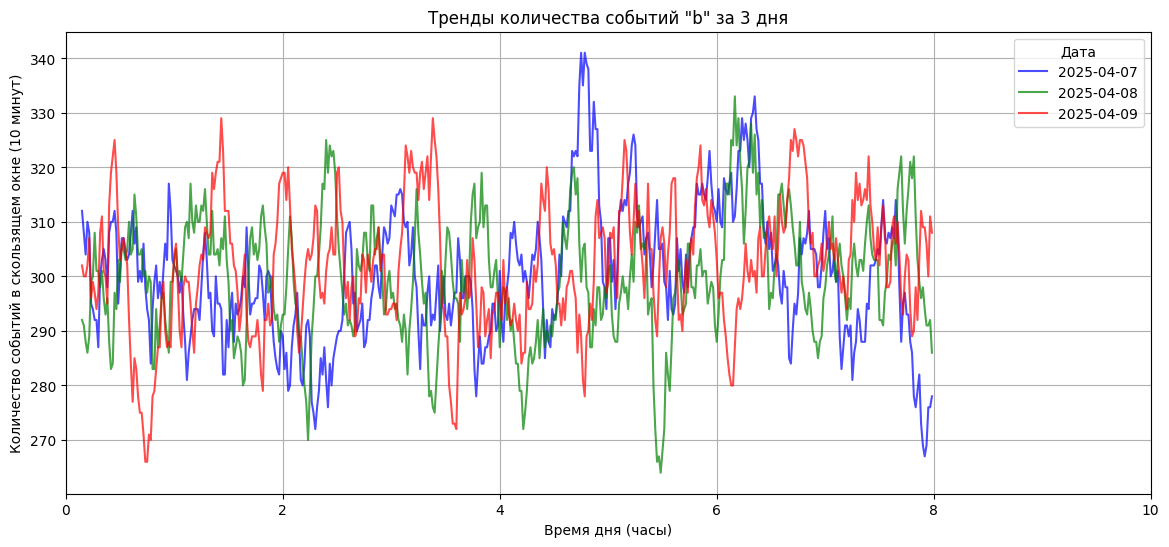

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Генерация данных для 3 дней
np.random.seed(42)
n_per_day = 28800  # Приблизительно 8 часов * 3600 секунд
timestamps_day1 = pd.date_range('2025-04-07', periods=n_per_day, freq='S')
timestamps_day2 = pd.date_range('2025-04-08', periods=n_per_day, freq='S')
timestamps_day3 = pd.date_range('2025-04-09', periods=n_per_day, freq='S')

data_day1 = {'timestamp': timestamps_day1, 'event': np.random.choice(['a', 'b'], size=n_per_day, p=[0.5, 0.5])}
data_day2 = {'timestamp': timestamps_day2, 'event': np.random.choice(['a', 'b'], size=n_per_day, p=[0.5, 0.5])}
data_day3 = {'timestamp': timestamps_day3, 'event': np.random.choice(['a', 'b'], size=n_per_day, p=[0.5, 0.5])}

df_day1 = pd.DataFrame(data_day1)
df_day2 = pd.DataFrame(data_day2)
df_day3 = pd.DataFrame(data_day3)

# Функция для расчета тренда с использованием скользящего окна
def calculate_trend(df, event_type, window_size=10, step_size='1T'):
    df_filtered = df[df['event'] == event_type].copy()
    df_filtered.set_index('timestamp', inplace=True)
    
    # Ресэмpling с шагом 1 минута и подсчет количества событий
    resampled_counts = df_filtered.resample(step_size).size()
    
    # Скользящее окно (10 минут с шагом 1 минута)
    rolling_counts = resampled_counts.rolling(window=window_size).sum()
    
    return rolling_counts

# Расчет трендов для каждого дня
trend_day1 = calculate_trend(df_day1, 'b')
trend_day2 = calculate_trend(df_day2, 'b')
trend_day3 = calculate_trend(df_day3, 'b')

# Преобразование индекса в числовой формат (часы с начала дня)
def convert_to_hours_since_midnight(index):
    return [
        t.hour + t.minute / 60 + t.second / 3600 
        for t in index.index.time
    ]

trend_day1_hours = convert_to_hours_since_midnight(trend_day1)
trend_day2_hours = convert_to_hours_since_midnight(trend_day2)
trend_day3_hours = convert_to_hours_since_midnight(trend_day3)

# Создание общего графика
plt.figure(figsize=(14, 6))

# Наложение трендов друг на друга
plt.plot(trend_day1_hours, trend_day1.values, label='2025-04-07', color='blue', alpha=0.7)
plt.plot(trend_day2_hours, trend_day2.values, label='2025-04-08', color='green', alpha=0.7)
plt.plot(trend_day3_hours, trend_day3.values, label='2025-04-09', color='red', alpha=0.7)

# Настройка графика
plt.title('Тренды количества событий "b" за 3 дня')
plt.xlabel('Время дня (часы)')
plt.ylabel('Количество событий в скользящем окне (10 минут)')
plt.legend(title='Дата')
plt.grid(True)

# Ограничение оси X до 24 часов
plt.xlim(0, 10)

plt.show()

In [60]:
pivot_df

date,2025-04-07,2025-04-08,2025-04-09
time_str,,,
00:00,NaN,19.0,17.0
00:01,NaN,41.0,39.0
00:02,NaN,66.0,52.0
00:03,NaN,87.0,64.0
00:04,NaN,102.0,79.0
...,...,...,...
23:55,0.0,0.0,NaN
23:56,0.0,0.0,NaN
23:57,0.0,0.0,NaN


C:\Users\user\AppData\Local\Temp\ipykernel_17696\3260442150.py:20: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  timestamps_day1 = pd.date_range('2025-04-07', periods=n_per_day, freq='S')
C:\Users\user\AppData\Local\Temp\ipykernel_17696\3260442150.py:21: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  timestamps_day2 = pd.date_range('2025-04-08', periods=n_per_day, freq='S')
C:\Users\user\AppData\Local\Temp\ipykernel_17696\3260442150.py:22: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  timestamps_day3 = pd.date_range('2025-04-09', periods=n_per_day, freq='S')
C:\Users\user\AppData\Local\Temp\ipykernel_17696\3260442150.py:39: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled_counts = df_filtered.resample(step_size).size()


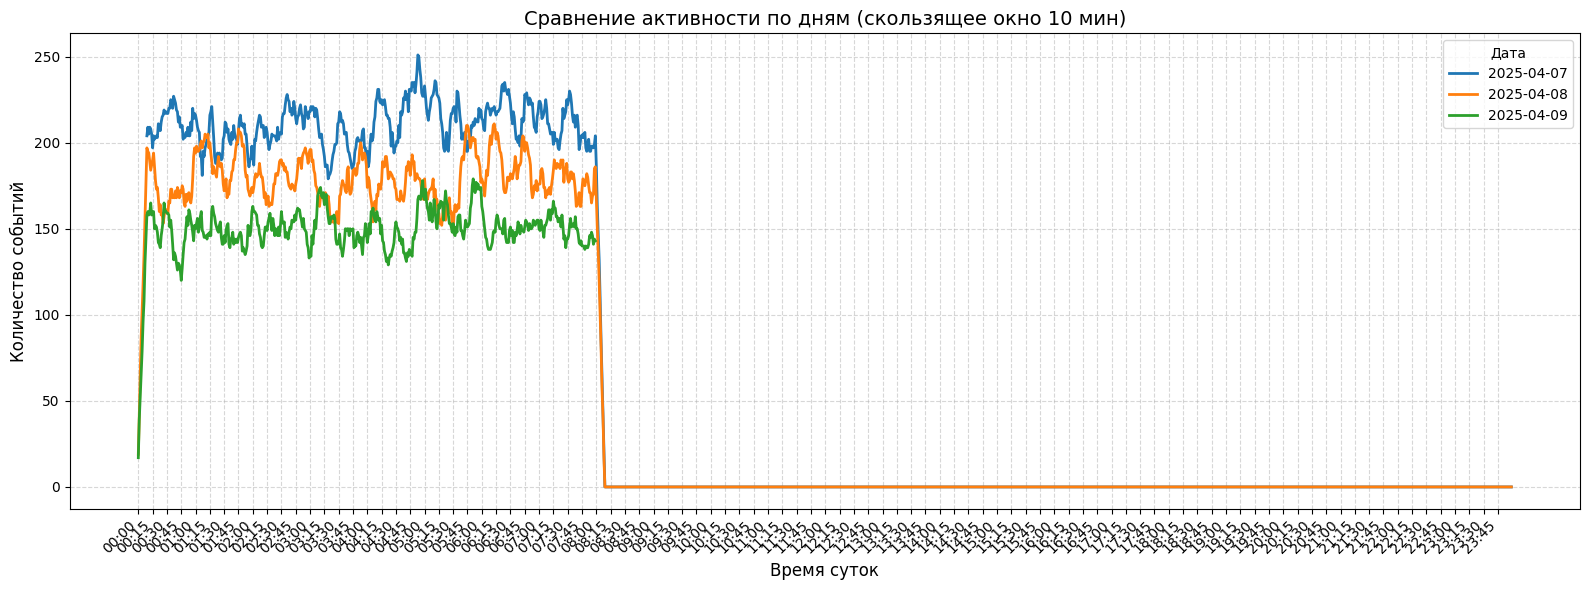

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Представим, что у нас есть готовый DataFrame `rolling_counts`
# Индекс — timestamp, колонка — count событий
# rolling_counts:
# timestamp               count
# 2025-04-07 00:00:00     12
# 2025-04-07 00:01:00     13
# 2025-04-08 00:00:00     8
# 2025-04-08 00:01:00     9
# ...
window_size=10
step_size='1T'

# Генерация данных для 3 дней
np.random.seed(42)
n_per_day = 28800  # Приблизительно 8 часов * 3600 секунд
timestamps_day1 = pd.date_range('2025-04-07', periods=n_per_day, freq='S')
timestamps_day2 = pd.date_range('2025-04-08', periods=n_per_day, freq='S')
timestamps_day3 = pd.date_range('2025-04-09', periods=n_per_day, freq='S')

data_day1 = {'timestamp': timestamps_day1, 'event': np.random.choice(['a', 'b', 'c', 'd'], size=n_per_day, p=[0.2, 0.25, 0.35, 0.2])}
data_day2 = {'timestamp': timestamps_day2, 'event': np.random.choice(['a', 'b', 'c', 'd'], size=n_per_day, p=[0.25, 0.2, 0.3, 0.25])}
data_day3 = {'timestamp': timestamps_day3, 'event': np.random.choice(['a', 'b', 'c', 'd'], size=n_per_day, p=[0.35, 0.15, 0.25, 0.25])}

df_day1 = pd.DataFrame(data_day1)
df_day2 = pd.DataFrame(data_day2)
df_day3 = pd.DataFrame(data_day3)

df_day_all = pd.concat([df_day1, df_day2, df_day3])

df_filtered = df_day_all[df_day_all['event'] == 'c'].copy()
#df_filtered = df_day_all.copy()
df_filtered.set_index('timestamp', inplace=True)

# Ресэмpling с шагом 1 минута и подсчет количества событий
resampled_counts = df_filtered.resample(step_size).size()

# Скользящее окно (10 минут с шагом 1 минута)
rolling_counts = resampled_counts.rolling(window=window_size).sum()

# Сбросим индекс
df = rolling_counts.reset_index()
df.columns = ['timestamp', 'count']

# Добавим колонки: дата и время суток
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['date'] = df['timestamp'].dt.date
df['time_str'] = df['timestamp'].dt.strftime('%H:%M')

# Пивот: строки — время, колонки — дата, значения — count
pivot_df = df.pivot(index='time_str', columns='date', values='count')
pivot_df = pivot_df.sort_index(key=lambda x: pd.to_datetime(x, format='%H:%M'))

#plt.style.use('seaborn-whitegrid')  # чистый стиль без серого

plt.figure(figsize=(16, 6))

# Отрисовка каждой линии
for col in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[col], label=str(col), linewidth=2)

# Настройка X-оси (время)
plt.xticks(ticks=range(0, len(pivot_df.index), 15),  # метки каждые 15 минут
           labels=pivot_df.index[::15], rotation=45, ha='right')

# Оформление
plt.title('Сравнение активности по дням (скользящее окно 10 мин)', fontsize=14)
plt.xlabel('Время суток', fontsize=12)
plt.ylabel('Количество событий', fontsize=12)
plt.legend(title='Дата', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()